In [391]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
%pip install torchsummary
from torchsummary import summary   
import re

Note: you may need to restart the kernel to use updated packages.


In [392]:
file_path = "shaky/text.txt"
text = open(file_path, 'r', encoding='utf-8').read()
text = text.split("\n")
text = " ".join(text).lower()
text = re.sub("[^a-zA-Z]", ' ', text)
words = text.split()

chars = sorted(list(set(words)))
ints = dict((c, i) for i, c in enumerate(chars))
int_to_word = {i: word for word, i in ints.items()}
n_chars = len(words)
n_vocab = len(chars)
print(len(ints))

11455


In [393]:
window = 15
dataX = []
dataY = []
for i in range(0, n_chars - window):
    text_in = words[i:i+window]
    text_out = words[i+window]
    dataX.append([ints[char] for char in text_in])
    dataY.append(ints[text_out])

print(dataX[5])
print(dataY[5])
print([int_to_word[word] for word in dataX[50]])
print(int_to_word[dataY[50]])

[402, 4166, 4705, 6139, 9229, 280, 9229, 9229, 3809, 1748, 11437, 476, 280, 8190, 7924]
10142
['let', 'us', 'kill', 'him', 'and', 'we', 'll', 'have', 'corn', 'at', 'our', 'own', 'price', 'is', 't']
a


In [394]:
# 100 x 1115283
# sample, timesteps, features
X = torch.LongTensor(dataX)
y = torch.LongTensor(dataY)
# X = torch.tensor(dataX, dtype=torch.long)
# y = torch.tensor(dataY).reshape(len(dataY), 1).float()
X.shape, y.shape


(torch.Size([208488, 15]), torch.Size([208488]))

In [395]:
import math
class PositionalEncoding(nn.Module):
    def __init__(self, max_len, d_model, dropout=0.1):
        """
        :param max_len: Input length sequence.
        :param d_model: Embedding dimension.
        :param dropout: Dropout value (default=0.1)
        """
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        """
        Inputs of forward function
        :param x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        """
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

In [399]:
 
class tnn(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, n_heads):
        super(tnn, self).__init__()
        self.pos_encoder = PositionalEncoding(max_len=15, d_model=hidden_dim)
        self.embedding = nn.Embedding(input_dim, hidden_dim)
        self.decoder_layer = nn.TransformerDecoderLayer(hidden_dim, n_heads, batch_first=True)
        self.decoder = nn.TransformerDecoder(self.decoder_layer, num_layers)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        x = self.embedding(x)
        sz = x.size(1) 
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        x = self.pos_encoder(x)
        x = self.decoder(x, memory=x, tgt_mask=mask, memory_mask=mask)
        x = self.dropout(x)
        x = self.fc(x[:, -1, :])
        return x

model = tnn(input_dim=n_vocab, hidden_dim=128, num_layers=16, n_heads=16)
criterion = nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters())
loader = DataLoader(torch.utils.data.TensorDataset(X, y), shuffle=True, batch_size=32)
params = sum(p.numel() for p in model.parameters())
print(params)

14152511


In [400]:
epochs = 50
losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0
    lenny = 0
    for X_batch, y_batch in loader:
        optimizer.zero_grad()
        pred = model(X_batch)
        loss = criterion(pred, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * X_batch.shape[0]
        lenny += X_batch.shape[0]
    epoch_loss = running_loss / lenny
    losses.append(epoch_loss)
    print("-" * 10)
    print(f"EPOCH {epoch+1}")
    print(f"Loss {epoch_loss}")

----------
EPOCH 1
Loss 214.96992714976565
----------
EPOCH 2
Loss 202.96851496496853
----------
EPOCH 3
Loss 197.51552010702295
----------
EPOCH 4
Loss 194.3447470255309
----------
EPOCH 5
Loss 191.90840451484365
----------
EPOCH 6
Loss 189.72071683601234
----------
EPOCH 7
Loss 187.86340266557397
----------
EPOCH 8
Loss 186.26106362196276
----------
EPOCH 9
Loss 184.60165646895814
----------
EPOCH 10
Loss 183.1736670337055
----------
EPOCH 11
Loss 181.75085132871575
----------
EPOCH 12
Loss 180.42690953326095
----------
EPOCH 13
Loss 179.0037857734262
----------
EPOCH 14
Loss 177.71452723610295
----------
EPOCH 15
Loss 176.6316256363034
----------
EPOCH 16
Loss 175.2691707575222
----------
EPOCH 17
Loss 174.26622427721574
----------
EPOCH 18
Loss 173.11502691905434
----------
EPOCH 19
Loss 171.95885672748037
----------
EPOCH 20
Loss 170.8194792921575
----------
EPOCH 21
Loss 169.8144748677937
----------
EPOCH 22
Loss 168.81665269428586
----------
EPOCH 23
Loss 167.7994383290158
-----

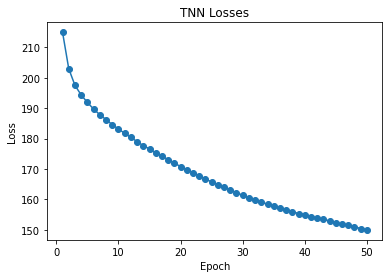

In [401]:
x = np.arange(1, 51)
plt.plot(x, losses, 'o-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('TNN Losses')
plt.show()

In [411]:
start = np.random.randint(0, len(words)-window)
prompt = words[start:start+window]
pattern = [ints[c] for c in prompt]
model.eval()
print('Prompt: "%s"' % " ".join(prompt))
print("--" * 10)
print("Generated Text: ", end = "")
with torch.no_grad():
    for i in range(15):
        x = torch.LongTensor(pattern).reshape(1, 15)
        pred = model(x)
        output = torch.tensor([seq.argmax() for seq in pred]).item()
        result = int_to_word[output]
        print(result, end=" ")
        pattern.append(output)
        pattern = pattern[1:]

Prompt: "fellow the general is my lover i have been the book of his good acts"
--------------------
Generated Text: are dedicate to the earth and that i am not in the world to thee 